<img src="./img/paper_author.png" width="1000" height="400">

<p align="center">
    <img src="./img/temporalcontrastcoding.png" alt="Image" width="700" height="700" />
</p>

run this to convert it to slides: `jupyter nbconvert SpikeEncoding.ipynb --to slides --no-prompt --TagRemovePreprocessor.remove_input_tags={\"to_remove\"}`

# Temporal Contrast Coding

<img src="./img/encoder_decoder_diagram.png" width="1000" height="400">

## $1^{st}$ temporal contrast encoding: <span style="color:red">Threshold-based representation (TBR)</span>


**Summary:** Compares the absolute signal change of an input signal with a threshold

**Advantages:**
1. Fast and simple
2. Reduce white noise by applying the threshold to small perturbations in the signal
3. No falsely registered values at the start or end of neither the spike train nor the reconstructed signal

**Disadvantages:**
1. Sensitive to strong white noise in the signal resulting in strong low-frequency artifact components
2. Tradeoff between representing small and large events. Since the whole sample length is considered for threshold value calculation, this encoding can be disadvantageous for long samples where there may be amplitude differences between events of different parts of the sample

### Compares the absolute signal change of an input signal with a threshold

<!-- <img src="./img/threshld-based-representation-annotated.png" width="400" height="400"> -->

<table><tr>
<td> <img src="./img/threshld-based-representation-annotated.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="./img/DVS_TBR.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

#### Load packages

In [1]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
import math
from scipy.stats import norm
from scipy import signal

#### Load signals generator

In [2]:
def noisy_sine_wave(a, f, phi, sigma, time):
    mySin  = np.vectorize(math.sin)
    return a*mySin(2*math.pi*f*time + phi*np.ones(len(time))) + np.random.rand(len(time))*sigma


def sum_of_sine_waves(a, f, phi, sigma, time):
    signal = np.zeros(len(time))
    for j in range(len(a)):
        signal = signal + noisy_sine_wave(a[j], f[j], phi[j], sigma, time)
    return signal


def noisy_gaussian_wave(a, m, s, sigma, time):
    return a*norm.pdf(time, m, s) + sigma*np.random.rand(len(time))


def sum_of_gaussian_wave(a, m, s, sigma, time):
    signal = np.zeros(len(time))
    for j in range(len(a)):
        signal = signal + noisy_gaussian_wave(a[j], m[j], s[j], 0, time) + np.random.rand(len(time))*sigma
    return signal

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def white_noise(rho, sr, n, mu=0):
    sigma = rho * np.sqrt(sr/2)
    noise = np.random.normal(mu, sigma, n)
    return noise

def sin_wave_generator(amp, f, n):
    time = np.linspace(0, p, n)
    signal = amp*np.sin(f*np.pi*time)
    return time,signal

#### Load encoder/decoder functions

In [3]:
def TBR_encoder(data, factor):
    # Based on algorithm provided in:
    #   Sengupta et al. (2017)
    #   Petro et al. (2020)
    diff = np.zeros(len(data)-1)
    spikes = np.zeros(len(data))
    for i in range(len(data)-1):
        diff[i] = data[i+1] - data[i]
    threshold = np.mean(diff) + factor * np.std(diff)
    diff = np.insert(diff, 0, diff[1])
    for i in range(len(data)):
        if diff[i] > threshold:
            spikes[i] = 1
        elif diff[i] < -threshold:
            spikes[i] = -1
    return spikes, threshold

def TBR_decoder(spikes, threshold):
    # Based on algorithm provided in:
    #   Sengupta et al. (2017)
    #   Petro et al. (2020)
    signal = np.zeros(len(spikes))
    for i in range(1, len(spikes)):
        if spikes[i] > 0:
            signal[i] = signal[i-1] + threshold
        elif spikes[i] < 0:
            signal[i] = signal[i-1] - threshold
        else:
            signal[i] = signal[i-1]
    return signal

### Threshold-based representation Encoder/Decoder (<span style="color:red">Signal conversion from analogue $\leftrightarrow$ spike train</span>)

##### factor = 1.005 

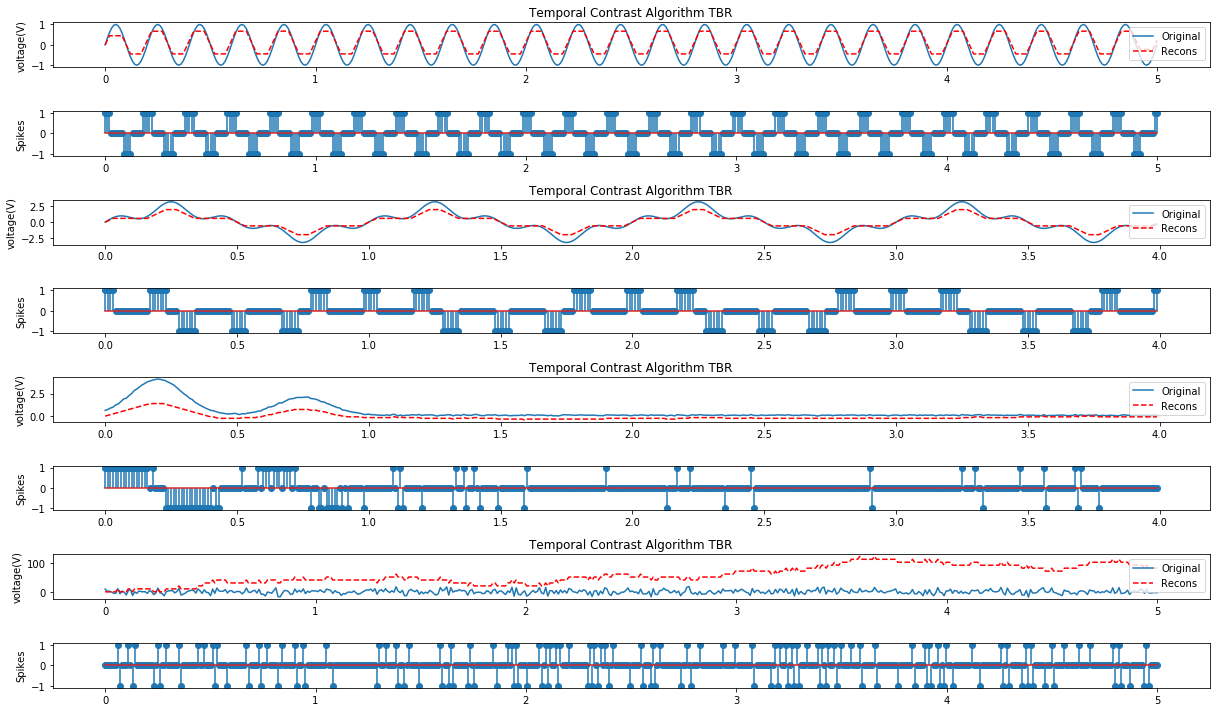

In [4]:
factor = 1.005 # TBR encoder factor
amp       = 1     # amplitude
rho       = 1     # spectral noise density unit/SQRT(Hz)
f         = 10    # frequency
n         = 500   # number of points
sr        = 100   # sample rate
p         = n/sr  # period
dt        = 0.01
T_max     = 4

(time,signal) = sin_wave_generator(amp, f, n)
noise = white_noise(rho, sr, n)
signal_white_noise = signal + noise

time_signal = np.arange(0, T_max, dt)
signal_sine_waves = sum_of_sine_waves([2, -0.5, 0.75], [1.0, 3.0, 5.0], [0.0, 0.0, 0.0], 0.0, time_signal)
signal_guassian_wave = sum_of_gaussian_wave([1, 0.5], [0.2, 0.75], [0.1, 0.1], 0.1, time_signal)

(spike_output,threshold) = TBR_encoder(signal, factor)
recon = TBR_decoder(spike_output, threshold)

(spike_output_white_noise,threshold) = TBR_encoder(signal_white_noise, factor)
recon_white_noise = TBR_decoder(spike_output_white_noise, threshold)

(spike_output_sinwave,threshold_sinwave) = TBR_encoder(signal_sine_waves, factor)
recon_sinwave = TBR_decoder(spike_output_sinwave, threshold_sinwave)

(spike_output_guassianwave,threshold_guassianwave) = TBR_encoder(signal_guassian_wave, factor)
recon_guassianwave = TBR_decoder(spike_output_guassianwave, threshold_guassianwave)

fig, axs = plt.subplots(8, 1,figsize=(17,10))
axs[0].plot(time, signal)
axs[0].plot(time, recon,'r--')
axs[0].set_ylabel('voltage(V)')
axs[0].legend(['Original','Recons'])
axs[0].set_title("Temporal Contrast Algorithm TBR")
axs[1].stem(time,spike_output,use_line_collection=True)
axs[1].set_ylabel('Spikes')

axs[2].plot(time_signal, signal_sine_waves)
axs[2].plot(time_signal, recon_sinwave,'r--')
axs[2].set_ylabel('voltage(V)')
axs[2].legend(['Original','Recons'])
axs[2].set_title("Temporal Contrast Algorithm TBR")
axs[3].stem(time_signal,spike_output_sinwave,use_line_collection=True)
axs[3].set_ylabel('Spikes')

axs[4].plot(time_signal, signal_guassian_wave)
axs[4].plot(time_signal, recon_guassianwave,'r--')
axs[4].set_ylabel('voltage(V)')
axs[4].legend(['Original','Recons'])
axs[4].set_title("Temporal Contrast Algorithm TBR")
axs[5].stem(time_signal,spike_output_guassianwave,use_line_collection=True)
axs[5].set_ylabel('Spikes')

axs[6].plot(time, signal_white_noise)
axs[6].plot(time, recon_white_noise,'r--')
axs[6].set_ylabel('voltage(V)')
axs[6].legend(['Original','Recons'])
axs[6].set_title("Temporal Contrast Algorithm TBR")
axs[7].stem(time,spike_output_white_noise,use_line_collection=True)
axs[7].set_ylabel('Spikes')
plt.tight_layout()
plt.show()

## $2^{nd}$ temporal contrast encoding: <span style="color:red">Step-Forward (SF)</span>

**Summary:** Uses the next available signal value and checks if the previous value (base) and an additional threshold is exceeded

**Advantages:**
1. The threshold can be chosen such that small and large amplitude events are both well represented
2. Noise in the signal is minimally reduced by the threshold
3. Due to the moving baseline, the reconstructed signal does not drift away even for longer signals (No overshoot)

**Disadvantages:**
They haven’t reported any disadvantage elsewhere

### Uses the next available signal value and checks if the previous value (base) and an additional threshold is exceeded

<img src="./img/step-forward-annotated.png" width="400" height="400">

#### Load encoder/decoder functions

In [5]:
def step_forward_encoder(data, threshold):
    # Based on algorithm provided in:
    #   Petro et al. (2020)
    startpoint = data[0]
    spikes = np.zeros(len(data))
    base = startpoint
    for i in range(1,len(data)):
        if data[i] > base + threshold:
            spikes[i] = 1
            base = base + threshold
        elif data[i] < base - threshold:
            spikes[i] = -1
            base = base - threshold
    return spikes, startpoint

def step_forward_decoder(spikes, threshold, startpoint):
    # Based on algorithm provided in:
    #   Petro et al. (2020)
    signal = np.zeros(len(spikes))
    signal[0] = startpoint
    for i in range(1,len(spikes)):
        if spikes[i] > 0:
            signal[i] = signal[i-1] + threshold
        elif spikes[i] < 0:
            signal[i] = signal[i-1] -threshold
        else:
            signal[i] = signal[i-1]
    return signal

### Step-forward Encoder/Decoder (<span style="color:red">Signal conversion from analogue $\leftrightarrow$ spike train</span>)

##### threshold = 0.26

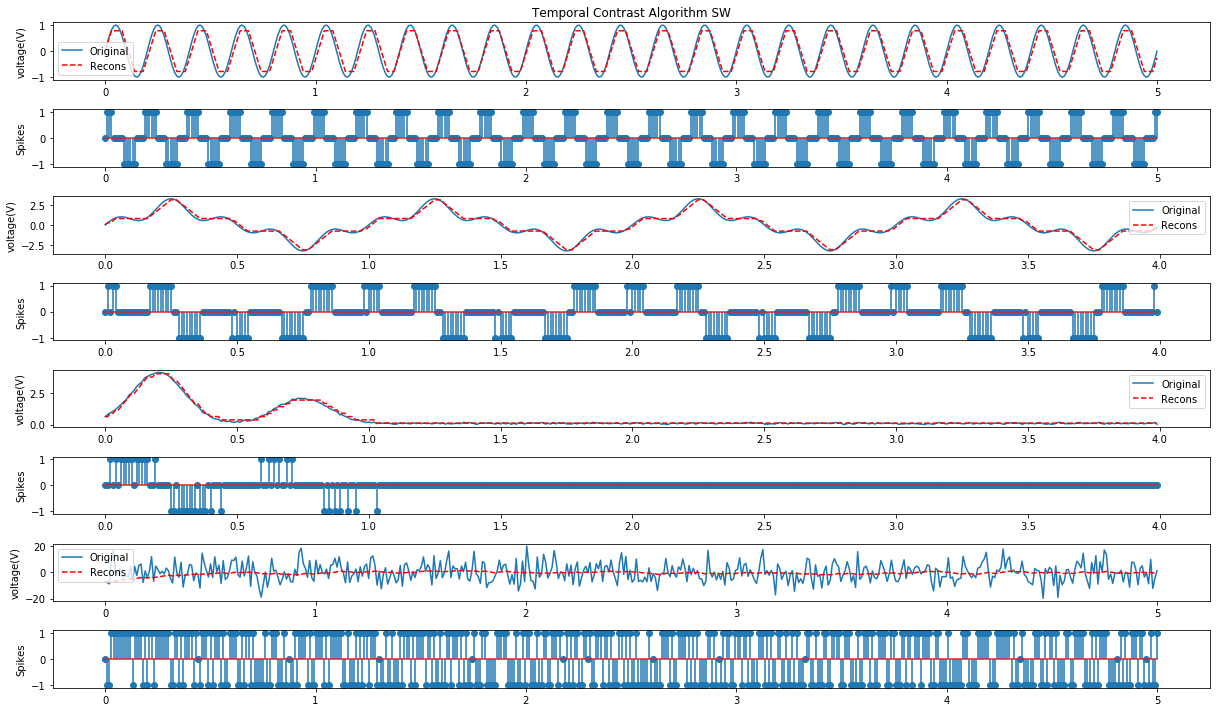

In [6]:
threshold = 0.26  # SF encoding parameters
amp       = 1     # amplitude
rho       = 1     # spectral noise density unit/SQRT(Hz)
f         = 10    # frequency
n         = 500   # number of points
sr        = 100   # sample rate
p         = n/sr  # period
dt        = 0.01
T_max     = 4

(time,signal) = sin_wave_generator(amp, f, n)
noise = white_noise(rho, sr, n)
signal_white_noise = signal + noise

time_signal = np.arange(0, T_max, dt)
signal_sine_waves = sum_of_sine_waves([2, -0.5, 0.75], [1.0, 3.0, 5.0], [0.0, 0.0, 0.0], 0.0, time_signal)
signal_guassian_wave = sum_of_gaussian_wave([1, 0.5], [0.2, 0.75], [0.1, 0.1], 0.1, time_signal)

(spike_output, start_point) = step_forward_encoder(signal, threshold)
recon = step_forward_decoder(spike_output,threshold,start_point)

(spike_output_white_noise,startpoint_white_noise) = step_forward_encoder(signal_white_noise, threshold)
recon_white_noise = step_forward_decoder(spike_output_white_noise,threshold, startpoint_white_noise)

(spike_output_sinwave,startpoint_sinwave) = step_forward_encoder(signal_sine_waves, threshold)
recon_sinwave = step_forward_decoder(spike_output_sinwave,threshold, startpoint_sinwave)

(spike_output_guassianwave,startpoint_guassianwave) = step_forward_encoder(signal_guassian_wave, threshold)
recon_guassianwave = step_forward_decoder(spike_output_guassianwave,threshold, startpoint_guassianwave)

fig, axs = plt.subplots(8, 1,figsize=(17,10))
axs[0].plot(time, signal)
axs[0].plot(time, recon,'r--')
axs[0].set_ylabel('voltage(V)')
axs[0].legend(['Original','Recons'])
axs[0].set_title("Temporal Contrast Algorithm SW")
axs[1].stem(time,spike_output,use_line_collection=True)
axs[1].set_ylabel('Spikes')

axs[2].plot(time_signal, signal_sine_waves)
axs[2].plot(time_signal, recon_sinwave,'r--')
axs[2].set_ylabel('voltage(V)')
axs[2].legend(['Original','Recons'])
axs[3].stem(time_signal,spike_output_sinwave,use_line_collection=True)
axs[3].set_ylabel('Spikes')

axs[4].plot(time_signal, signal_guassian_wave)
axs[4].plot(time_signal, recon_guassianwave,'r--')
axs[4].set_ylabel('voltage(V)')
axs[4].legend(['Original','Recons'])
axs[5].stem(time_signal,spike_output_guassianwave,use_line_collection=True)
axs[5].set_ylabel('Spikes')

axs[6].plot(time, signal_white_noise)
axs[6].plot(time, recon_white_noise,'r--')
axs[6].set_ylabel('voltage(V)')
axs[6].legend(['Original','Recons'])
axs[7].stem(time,spike_output_white_noise,use_line_collection=True)
axs[7].set_ylabel('Spikes')
plt.tight_layout()
plt.show()

## $3^{rd}$ temporal contrast encoding: <span style="color:red">Moving window (MW)</span>

**Summary:** Uses a base which is defined by the mean of the previous signal in a time window

**Advantages:**
1. It is robust against white noise
2. Moving averge is an optimal smoothing filter in the time domain against white noise
3. Could be used to filter out a strong, artifact frequency component, e.g., power line noise in EEG signals

**Disadvantages:**
1. Window size heavily affect the cutoff frequency, the slope of the frequency response ad the noise reduction
2. The signal beginning is not encoded well until the window size is reached, therefore it requires tricks to adjust the baseline
3. Overshoot-type errors often appear

### Uses a base which is defined by the mean of the previous signal in a time window

<img src="./img/moving-window-annotated.png" width="400" height="400">

#### Load encoder/decoder functions

In [55]:
def moving_window_encoder(data, threshold, window):
    # Based on algorithm provided in:
    #   Petro et al. (2020)
    startpoint = data[0]
    spikes = np.zeros(len(data))
    base = np.mean(data[0:window+1])
    for i in range(window+1):
        if data[i] > base + threshold:
            spikes[i] = 1
        elif data[i] < base - threshold:
            spikes[i] = -1
    for i in range(window+2, len(data)):
        base = np.mean(data[(i-window-1):(i-1)])
        if data[i] > base + threshold:
            spikes[i] = 1
        elif data[i] < base - threshold:
            spikes[i] = -1
    return spikes, startpoint

def moving_window_decoder(spikes, threshold, startpoint):
    # Based on algorithm provided in:
    #   Petro et al. (2020)
    signal = np.zeros(len(spikes))
    signal[0] = startpoint
    for i in range(1,len(spikes)):
        if spikes[i] > 0:
            signal[i] = signal[i-1] + threshold
        elif spikes[i] < 0:
            signal[i] = signal[i-1] - threshold
        else:
            signal[i] = signal[i-1]
    return signal

### Moving Window Encoder/Decoder (<span style="color:red">Signal conversion from analogue $\leftrightarrow$ spike train</span>)

##### window    = 3  & threshold = 0.2

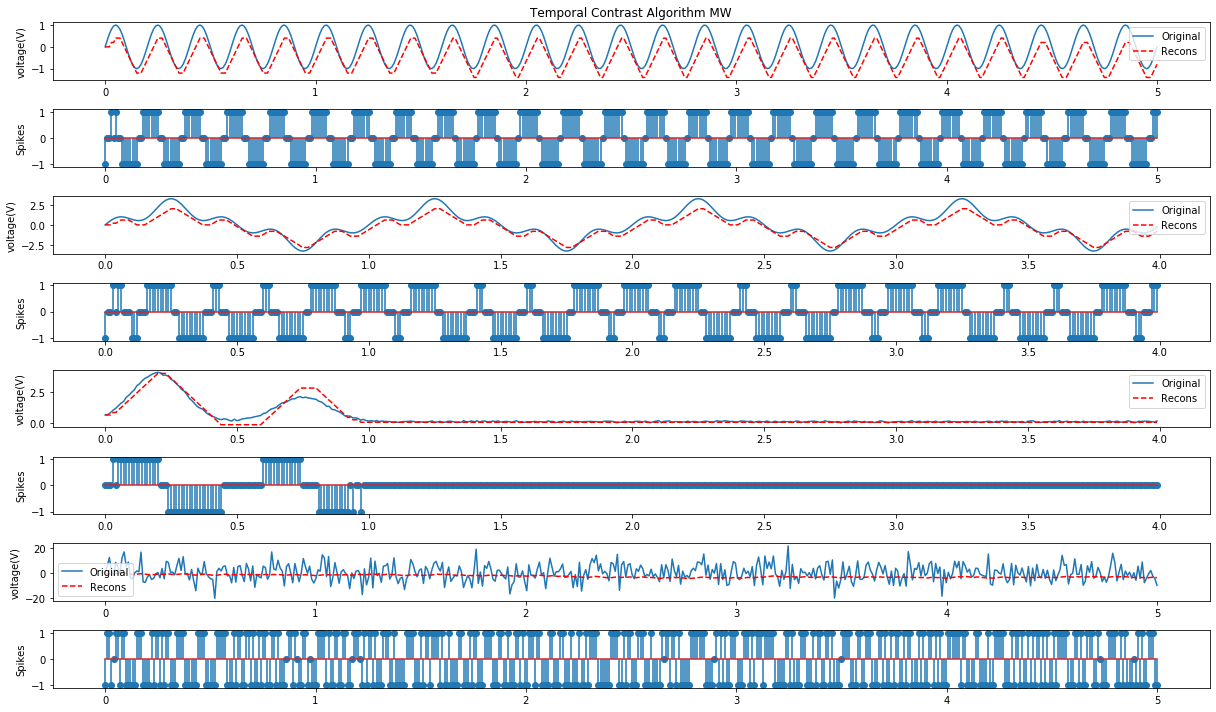

In [56]:
window    = 3     # MW encoding parameters
threshold = 0.2   # MW encoding parameters
amp       = 1     # amplitude
rho       = 1     # spectral noise density unit/SQRT(Hz)
f         = 10    # frequency
n         = 500   # number of points
sr        = 100   # sample rate
p         = n/sr  # period

dt        = 0.01
T_max     = 4

(time,signal) = sin_wave_generator(amp, f, n)
noise = white_noise(rho, sr, n)
signal_white_noise = signal + noise

time_signal = np.arange(0, T_max, dt)
signal_sine_waves = sum_of_sine_waves([2, -0.5, 0.75], [1.0, 3.0, 5.0], [0.0, 0.0, 0.0], 0.0, time_signal)
signal_guassian_wave = sum_of_gaussian_wave([1, 0.5], [0.2, 0.75], [0.1, 0.1], 0.1, time_signal)

(spike_output, start_point) = moving_window_encoder(signal, threshold,window)
recon = moving_window_decoder(spike_output,threshold,start_point)

(spike_output_white_noise,startpoint_white_noise) = moving_window_encoder(signal_white_noise, threshold,window)
recon_white_noise = moving_window_decoder(spike_output_white_noise,threshold, startpoint_white_noise)

(spike_output_sinwave,startpoint_sinwave) = moving_window_encoder(signal_sine_waves, threshold,window)
recon_sinwave = moving_window_decoder(spike_output_sinwave,threshold, startpoint_sinwave)

(spike_output_guassianwave,startpoint_guassianwave) = moving_window_encoder(signal_guassian_wave, threshold,window)
recon_guassianwave = moving_window_decoder(spike_output_guassianwave,threshold, startpoint_guassianwave)

fig, axs = plt.subplots(8, 1,figsize=(17,10))
axs[0].plot(time, signal)
axs[0].plot(time, recon,'r--')
axs[0].set_ylabel('voltage(V)')
axs[0].legend(['Original','Recons'])
axs[0].set_title("Temporal Contrast Algorithm MW")
axs[1].stem(time,spike_output,use_line_collection=True)
axs[1].set_ylabel('Spikes')

axs[2].plot(time_signal, signal_sine_waves)
axs[2].plot(time_signal, recon_sinwave,'r--')
axs[2].set_ylabel('voltage(V)')
axs[2].legend(['Original','Recons'])
axs[3].stem(time_signal,spike_output_sinwave,use_line_collection=True)
axs[3].set_ylabel('Spikes')

axs[4].plot(time_signal, signal_guassian_wave)
axs[4].plot(time_signal, recon_guassianwave,'r--')
axs[4].set_ylabel('voltage(V)')
axs[4].legend(['Original','Recons'])
axs[5].stem(time_signal,spike_output_guassianwave,use_line_collection=True)
axs[5].set_ylabel('Spikes')

axs[6].plot(time, signal_white_noise)
axs[6].plot(time, recon_white_noise,'r--')
axs[6].set_ylabel('voltage(V)')
axs[6].legend(['Original','Recons'])
axs[7].stem(time,spike_output_white_noise,use_line_collection=True)
axs[7].set_ylabel('Spikes')
plt.tight_layout()
plt.show()

## $4^{th}$ temporal contrast encoding: <span style="color:red">Ben's spike algorithm (BSA)</span>

**Summary:**
Makes the decision to spike by comparing an errors measure to a threshold, but can only process inputs of a specific range

**Advantages:**


**Disadvantages:**

###  Makes the decision to spike by comparing an errors measure to a threshold, but can only process inputs of a specific range

<img src="./img/BSA-annotated.png" width="400" height="400">

#### Load encoder/decoder functions

In [57]:
def ben_spike_encoder(data, fir, threshold):
    # Based on algorithm provided in:
    #   Petro et al. (2020)
    #   Sengupta et al. (2017)
    #   Schrauwen et al. (2003)
    spikes = np.zeros(len(data))
    shift = min(data)
    data = data - shift*np.ones(len(data))
    for i in range(len(data)-len(fir)+1):
        err1 = 0
        err2 = 0
        for j in range(len(fir)):
            err1 = err1 + abs(data[i+j] - fir[j])
            err2 = err2 + abs(data[i+j-1])
        if err1 <= err2*threshold:
            spikes[i] = 1
            for j in range(len(fir)):
                if i+j+1 < len(data):
                    data[i+j+1] = data[i+j+1] - fir[j]
    return spikes, shift

def ben_spike_decoder(spikes, fir, shift):
    # Based on algorithm provided in:
    #   Petro et al. (2020)
    #   Sengupta et al. (2017)
    #   Schrauwen et al. (2003)
    signal = np.convolve(spikes, fir)
    signal = signal + shift*np.ones(len(signal))
    signal = signal[0:(len(signal)-len(fir)+1)]
    return signal

### BSA Encoder/Decoder (<span style="color:red">Signal conversion from analogue $\leftrightarrow$ spike train</span>)

##### threshold = 1.175

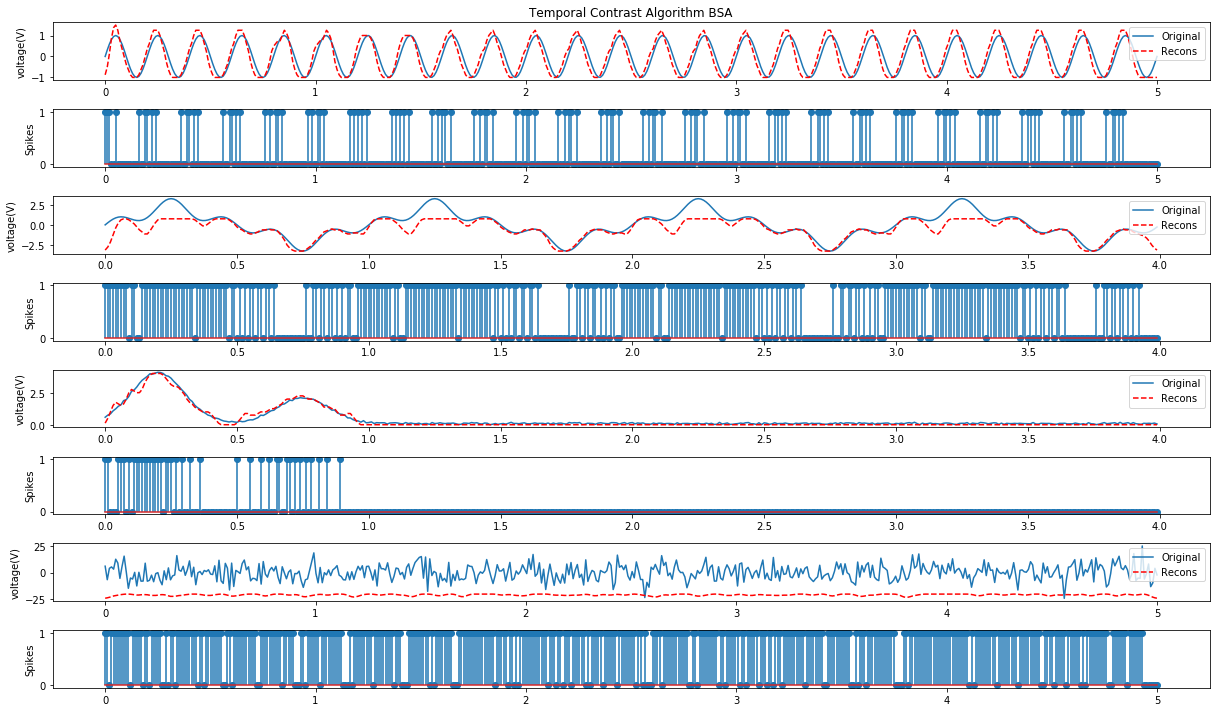

In [63]:
from scipy import signal

bsa_thresholds = [1.175, 1.05, 1.2]
amp       = 1     # amplitude
rho       = 1     # spectral noise density unit/SQRT(Hz)
f         = 10    # frequency
n         = 500   # number of points
sr        = 100   # sample rate
p         = n/sr  # period
dt        = 0.01
T_max     = 4

bsa_window = [9, 10, 8]

fir = signal.triang(bsa_window[0])
fir= norm.pdf(np.linspace(1, bsa_window[1], bsa_window[1]), 1.5, 3.5)
fir= signal.triang(bsa_window[2])

(time,signal) = sin_wave_generator(amp, f, n)
noise = white_noise(rho, sr, n)
signal_white_noise = signal + noise

time_signal = np.arange(0, T_max, dt)
signal_sine_waves = sum_of_sine_waves([2, -0.5, 0.75], [1.0, 3.0, 5.0], [0.0, 0.0, 0.0], 0.0, time_signal)
signal_guassian_wave = sum_of_gaussian_wave([1, 0.5], [0.2, 0.75], [0.1, 0.1], 0.1, time_signal)

(spike_output, shift) = ben_spike_encoder(signal, fir, bsa_thresholds[1])
recon = ben_spike_decoder(spike_output, fir, shift)

(spike_output_white_noise,shift_white_noise) = ben_spike_encoder(signal_white_noise, fir, bsa_thresholds[1])
recon_white_noise = ben_spike_decoder(spike_output_white_noise,fir, shift_white_noise)

(spike_output_sinwave,shift_sinwave) = ben_spike_encoder(signal_sine_waves, fir, bsa_thresholds[1])
recon_sinwave = ben_spike_decoder(spike_output_sinwave,fir, shift_sinwave)

(spike_output_guassianwave,shift_guassianwave) = ben_spike_encoder(signal_guassian_wave, fir, bsa_thresholds[1])
recon_guassianwave = ben_spike_decoder(spike_output_guassianwave,fir, shift_guassianwave)

fig, axs = plt.subplots(8, 1,figsize=(17,10))
axs[0].plot(time, signal)
axs[0].plot(time, recon,'r--')
axs[0].set_ylabel('voltage(V)')
axs[0].legend(['Original','Recons'])
axs[0].set_title("Temporal Contrast Algorithm BSA")
axs[1].stem(time,spike_output,use_line_collection=True)
axs[1].set_ylabel('Spikes')

axs[2].plot(time_signal, signal_sine_waves)
axs[2].plot(time_signal, recon_sinwave,'r--')
axs[2].set_ylabel('voltage(V)')
axs[2].legend(['Original','Recons'])
axs[3].stem(time_signal,spike_output_sinwave,use_line_collection=True)
axs[3].set_ylabel('Spikes')

axs[4].plot(time_signal, signal_guassian_wave)
axs[4].plot(time_signal, recon_guassianwave,'r--')
axs[4].set_ylabel('voltage(V)')
axs[4].legend(['Original','Recons'])
axs[5].stem(time_signal,spike_output_guassianwave,use_line_collection=True)
axs[5].set_ylabel('Spikes')

axs[6].plot(time, signal_white_noise)
axs[6].plot(time, recon_white_noise,'r--')
axs[6].set_ylabel('voltage(V)')
axs[6].legend(['Original','Recons'])
axs[7].stem(time,spike_output_white_noise,use_line_collection=True)
axs[7].set_ylabel('Spikes')
plt.tight_layout()
plt.show()

## $5^{th}$ temporal contrast encoding: <span style="color:red">Hough spike algorithm (HSA)</span>

**Summary:**

**Advantages:**


**Disadvantages:**

#### Load encoder/decoder functions

In [64]:
def hough_spike_encoder(data, fir):
    # Based on algorithm provided in:
    #   Schrauwen et al. (2003)
    spikes = np.zeros(len(data))
    shift = min(data)
    data = data - shift*np.ones(len(data))
    for i in range(len(data)):
        count = 0
        for j in range(len(fir)):
            if i+j < len(data):
                if data[i+j] >= fir[j]:
                    count = count + 1
        if count == len(fir):
            spikes[i] = 1
            for j in range(len(fir)):
                if i+j < len(data):
                    data[i+j] = data[i+j] - fir[j]
    return spikes, shift

def hough_spike_decoder(spikes, fir, shift):
    # Based on algorithm provided in:
    #   Petro et al. (2020)
    #   Sengupta et al. (2017)
    #   Schrauwen et al. (2003)
    signal = np.convolve(spikes, fir)
    signal = signal + shift*np.ones(len(signal))
    signal = signal[0:(len(signal)-len(fir)+1)]
    return signal

### HSA Encoder/Decoder (<span style="color:red">Signal conversion from analogue $\leftrightarrow$ spike train</span>)

##### window = 12

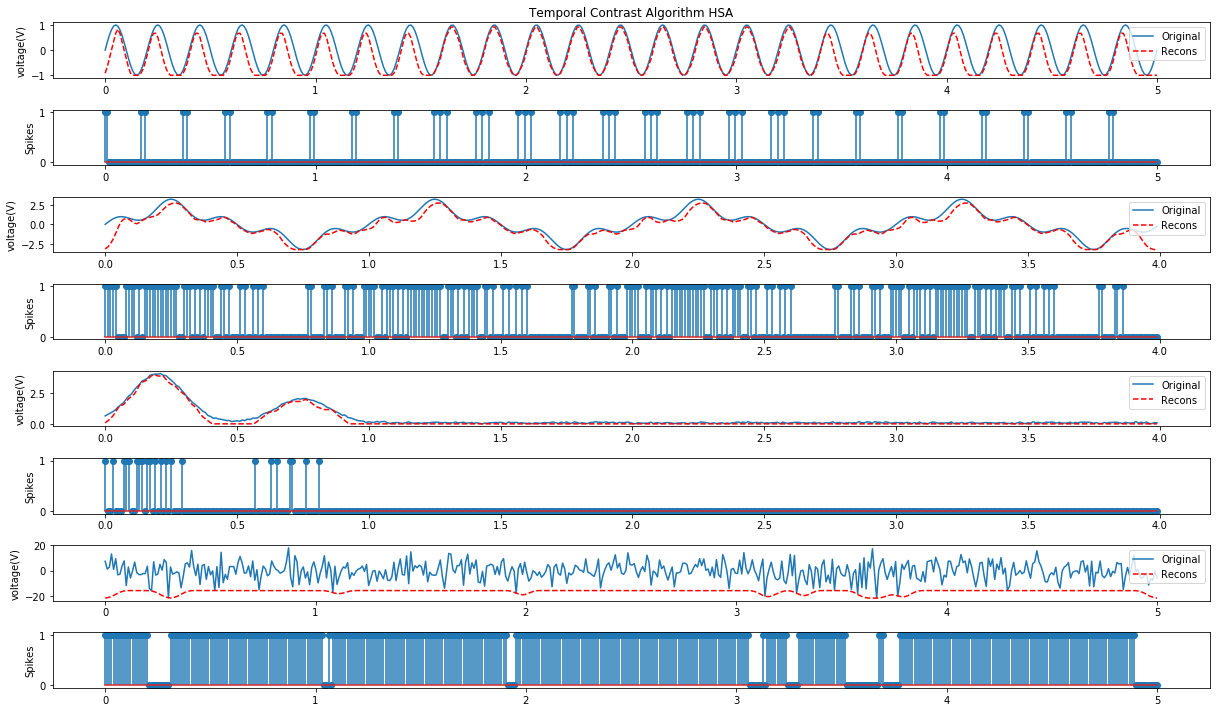

In [65]:
from scipy import signal

hsa_window = [12, 15, 12]
hsa_m_thresholds = [0.85, 0.05, 0.5]
amp       = 1     # amplitude
rho       = 1     # spectral noise density unit/SQRT(Hz)
f         = 10    # frequency
n         = 500   # number of points
sr        = 100   # sample rate
p         = n/sr  # period
dt        = 0.01
T_max     = 4


hsa_fir = signal.triang(hsa_window[0])
hsa_fir=norm.pdf(np.linspace(1, hsa_window[1], hsa_window[1]), 1.5, 3.5)
hsa_fir=signal.triang(hsa_window[2])

(time,signal) = sin_wave_generator(amp, f, n)
noise = white_noise(rho, sr, n)
signal_white_noise = signal + noise

time_signal = np.arange(0, T_max, dt)
signal_sine_waves = sum_of_sine_waves([2, -0.5, 0.75], [1.0, 3.0, 5.0], [0.0, 0.0, 0.0], 0.0, time_signal)
signal_guassian_wave = sum_of_gaussian_wave([1, 0.5], [0.2, 0.75], [0.1, 0.1], 0.1, time_signal)

(spike_output, shift) = hough_spike_encoder(signal, hsa_fir)
recon = hough_spike_decoder(spike_output, hsa_fir, shift)

(spike_output_white_noise,shift_white_noise) = hough_spike_encoder(signal_white_noise, hsa_fir)
recon_white_noise = hough_spike_decoder(spike_output_white_noise,hsa_fir, shift_white_noise)

(spike_output_sinwave,shift_sinwave) = hough_spike_encoder(signal_sine_waves, hsa_fir)
recon_sinwave = hough_spike_decoder(spike_output_sinwave,hsa_fir, shift_sinwave)

(spike_output_guassianwave,shift_guassianwave) = hough_spike_encoder(signal_guassian_wave, hsa_fir)
recon_guassianwave = hough_spike_decoder(spike_output_guassianwave,hsa_fir, shift_guassianwave)

fig, axs = plt.subplots(8, 1,figsize=(17,10))
axs[0].plot(time, signal)
axs[0].plot(time, recon,'r--')
axs[0].set_ylabel('voltage(V)')
axs[0].legend(['Original','Recons'])
axs[0].set_title("Temporal Contrast Algorithm HSA")
axs[1].stem(time,spike_output,use_line_collection=True)
axs[1].set_ylabel('Spikes')

axs[2].plot(time_signal, signal_sine_waves)
axs[2].plot(time_signal, recon_sinwave,'r--')
axs[2].set_ylabel('voltage(V)')
axs[2].legend(['Original','Recons'])
axs[3].stem(time_signal,spike_output_sinwave,use_line_collection=True)
axs[3].set_ylabel('Spikes')

axs[4].plot(time_signal, signal_guassian_wave)
axs[4].plot(time_signal, recon_guassianwave,'r--')
axs[4].set_ylabel('voltage(V)')
axs[4].legend(['Original','Recons'])
axs[5].stem(time_signal,spike_output_guassianwave,use_line_collection=True)
axs[5].set_ylabel('Spikes')

axs[6].plot(time, signal_white_noise)
axs[6].plot(time, recon_white_noise,'r--')
axs[6].set_ylabel('voltage(V)')
axs[6].legend(['Original','Recons'])
axs[7].stem(time,spike_output_white_noise,use_line_collection=True)
axs[7].set_ylabel('Spikes')
plt.tight_layout()
plt.show()

## $6^{th}$ temporal contrast encoding: <span style="color:red">Modified Hough spike algorithm (MHSA)</span>

**Summary:**

**Advantages:**


**Disadvantages:**

#### Load encoder/decoder functions

In [66]:
def modified_hough_spike_encoder(data, fir, threshold):
    # Based on algorithm provided in:
    #   Schrauwen et al. (2003)
    spikes = np.zeros(len(data))
    shift = min(data)
    data = data - shift*np.ones(len(data))
    for i in range(len(data)):
        error = 0
        for j in range(len(fir)):
            if i+j < len(data):
                if data[i+j] < fir[j]:
                    error = error + fir[j] - data[i+j]
        if error <= threshold:
            spikes[i] = 1
            for j in range(len(fir)):
                if i+j < len(data):
                    data[i+j] = data[i+j] - fir[j]
    return spikes, shift


def modified_hough_spike_decoder(spikes, fir, shift):
    # Based on algorithm provided in:
    #   Petro et al. (2020)
    #   Sengupta et al. (2017)
    #   Schrauwen et al. (2003)
    signal = np.convolve(spikes, fir)
    signal = signal + shift*np.ones(len(signal))
    signal = signal[0:(len(signal)-len(fir)+1)]
    return signal

### MHSA Encoder/Decoder (<span style="color:red">Signal conversion from analogue $\leftrightarrow$ spike train</span>)

##### thresholds = 0.85

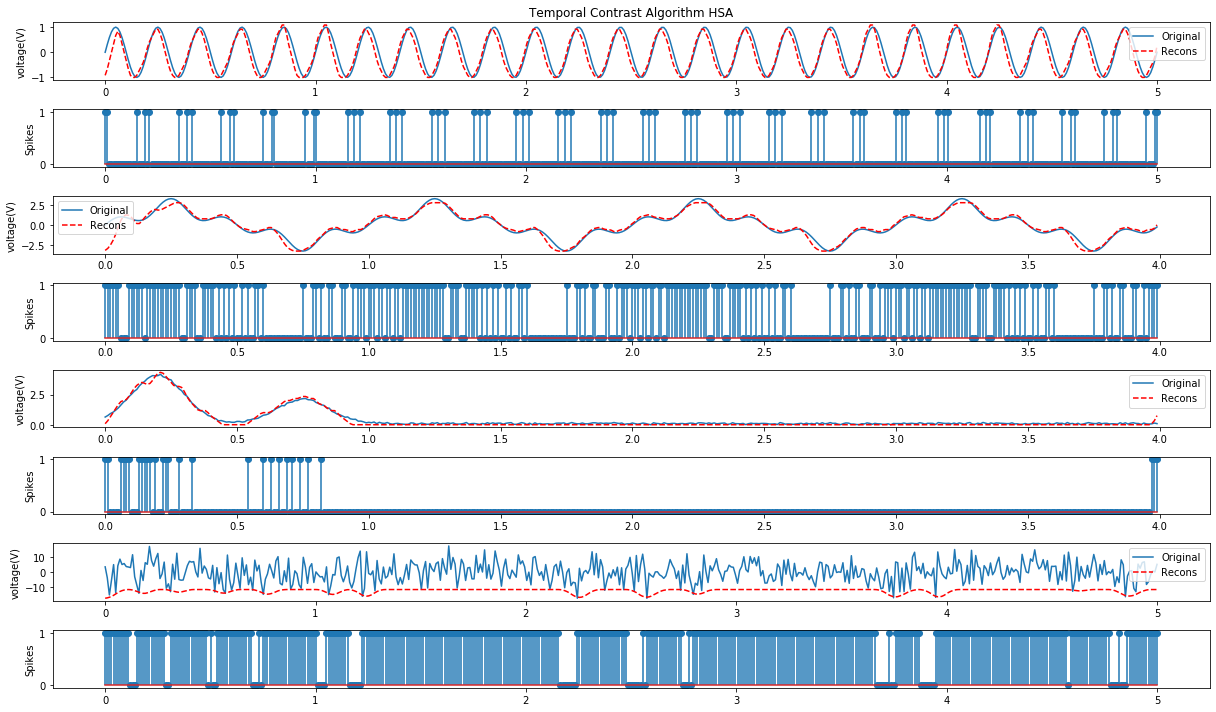

In [67]:
from scipy import signal

hsa_m_thresholds = [0.85, 0.05, 0.5]
hsa_window = [12, 15, 12]

amp       = 1     # amplitude
rho       = 1     # spectral noise density unit/SQRT(Hz)
f         = 10    # frequency
n         = 500   # number of points
sr        = 100   # sample rate
p         = n/sr  # period
dt        = 0.01
T_max     = 4


hsa_fir = signal.triang(hsa_window[0])
hsa_fir=norm.pdf(np.linspace(1, hsa_window[1], hsa_window[1]), 1.5, 3.5)
hsa_fir=signal.triang(hsa_window[2])

(time,signal) = sin_wave_generator(amp, f, n)
noise = white_noise(rho, sr, n)
signal_white_noise = signal + noise

time_signal = np.arange(0, T_max, dt)
signal_sine_waves = sum_of_sine_waves([2, -0.5, 0.75], [1.0, 3.0, 5.0], [0.0, 0.0, 0.0], 0.0, time_signal)
signal_guassian_wave = sum_of_gaussian_wave([1, 0.5], [0.2, 0.75], [0.1, 0.1], 0.1, time_signal)

(spike_output, shift) = modified_hough_spike_encoder(signal, hsa_fir, hsa_m_thresholds[0])
recon = modified_hough_spike_decoder(spike_output, hsa_fir, shift)

(spike_output_white_noise,shift_white_noise) = modified_hough_spike_encoder(signal_white_noise, hsa_fir,hsa_m_thresholds[0])
recon_white_noise = modified_hough_spike_decoder(spike_output_white_noise,hsa_fir, shift_white_noise)

(spike_output_sinwave,shift_sinwave) = modified_hough_spike_encoder(signal_sine_waves, hsa_fir,hsa_m_thresholds[0])
recon_sinwave = modified_hough_spike_decoder(spike_output_sinwave,hsa_fir, shift_sinwave)

(spike_output_guassianwave,shift_guassianwave) = modified_hough_spike_encoder(signal_guassian_wave, hsa_fir,hsa_m_thresholds[0])
recon_guassianwave = modified_hough_spike_decoder(spike_output_guassianwave,hsa_fir, shift_guassianwave)

fig, axs = plt.subplots(8, 1,figsize=(17,10))
axs[0].plot(time, signal)
axs[0].plot(time, recon,'r--')
axs[0].set_ylabel('voltage(V)')
axs[0].legend(['Original','Recons'])
axs[0].set_title("Temporal Contrast Algorithm HSA")
axs[1].stem(time,spike_output,use_line_collection=True)
axs[1].set_ylabel('Spikes')

axs[2].plot(time_signal, signal_sine_waves)
axs[2].plot(time_signal, recon_sinwave,'r--')
axs[2].set_ylabel('voltage(V)')
axs[2].legend(['Original','Recons'])
axs[3].stem(time_signal,spike_output_sinwave,use_line_collection=True)
axs[3].set_ylabel('Spikes')

axs[4].plot(time_signal, signal_guassian_wave)
axs[4].plot(time_signal, recon_guassianwave,'r--')
axs[4].set_ylabel('voltage(V)')
axs[4].legend(['Original','Recons'])
axs[5].stem(time_signal,spike_output_guassianwave,use_line_collection=True)
axs[5].set_ylabel('Spikes')

axs[6].plot(time, signal_white_noise)
axs[6].plot(time, recon_white_noise,'r--')
axs[6].set_ylabel('voltage(V)')
axs[6].legend(['Original','Recons'])
axs[7].stem(time,spike_output_white_noise,use_line_collection=True)
axs[7].set_ylabel('Spikes')
plt.tight_layout()
plt.show()